In [10]:
# Installing necessary dependencies Qiskit

import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit_ibm_provider import IBMProvider
from qiskit import pulse, transpile                
from qiskit.circuit import QuantumCircuit, Gate, Parameter
from qiskit.tools.monitor import job_monitor

In [11]:
# Qutritium

from src.utility import fit_function
from src.analyzer import DataAnalysis

In [12]:
provider = IBMProvider(token="b751d05f9c3522f9d46a851e2830dfa0d6087643fcdda1588b781e2f349cbaa8c6d7b1dbec1ec3262857523289bb385ee8ad7b86a83c045ca69aba6b1bc4b3d8")
backends = provider.backends()
for backend in backends:
    print(f"{backend.name}")

simulator_mps
simulator_stabilizer
ibm_perth
ibm_brisbane
ibmq_qasm_simulator
simulator_extended_stabilizer
simulator_statevector
ibm_nairobi
ibm_lagos


In [13]:
backend = provider.get_backend(name="ibm_brisbane")
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()
print(backend.properties())

In [14]:
GHz = 1.0e9
MHz = 1.0e6
qubit, cbit = 0, 0
num_qubit, num_cbit = 1, 1
us = 1.0e-6
ns = 1.0e-9

scale_factor = 1.0e-7

default_num_shots = 4096

# Frequency $\omega_{01}$ probe

In [15]:
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]  
frequency_span_Hz = 40 * MHz
frequency_step_Hz = 0.5 * MHz

frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_01_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

In [16]:
sweep_gate = Gate("sweep", 1, [])

frequencies_Hz = frequencies_01_GHz*GHz
sweep01_circs = []

for f in frequencies_Hz:
    qc_sweep = QuantumCircuit(qubit+1, cbit+1)
    qc_sweep.append(sweep_gate, [0])
    with pulse.build(backend=backend) as sweep_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f, drive_chan)
        pulse.play(pulse.Gaussian(duration=144, sigma=144/4, amp=0.1), drive_chan)
    qc_sweep.add_calibration(sweep_gate, [0], sweep_sched)
    qc_sweep.measure(qubit, cbit)
    sweep01_circs.append(qc_sweep)

In [17]:
sweep01_circs = transpile(sweep01_circs, backend=backend)

json_decoder.target_from_server_data:WARNING:2023-11-11 15:18:58,344: Definition of instruction switch_case is not found in the Qiskit namespace and GateConfig is not provided by the BackendConfiguration payload. Qiskit Gate model cannot be instantiated for this instruction and this instruction is silently excluded from the Target. Please add new gate class to Qiskit or provide GateConfig for this name.


RuntimeError: Set changed size during iteration

In [30]:
run_sweep01 = True
if run_sweep01 == True:
    sweep01_job = execute(experiments=sweep01_circs,
                          backend=backend,
                          shots=default_num_shots,
                          meas_return='avg',
                          meas_level=1)
    print(sweep01_job.job_id())
    job_monitor(sweep01_job)

json_decoder.target_from_server_data:WARNING:2023-11-11 14:00:49,225: Definition of instruction switch_case is not found in the Qiskit namespace and GateConfig is not provided by the BackendConfiguration payload. Qiskit Gate model cannot be instantiated for this instruction and this instruction is silently excluded from the Target. Please add new gate class to Qiskit or provide GateConfig for this name.


RuntimeError: Set changed size during iteration

In [16]:
sweep01_job = provider.backend.retrieve_job('chmdp9hike34bjioctlg')

IBMBackendApiError: 'Failed to get job chmdp9hike34bjioctlg: \'404 Client Error: Not Found for url: https://api.quantum-computing.ibm.com/runtime/facade/v1/jobs/chmdp9hike34bjioctlg/type. {"errors":[{"code":1291,"message":"Job not found. Job ID: chmdp9hike34bjioctlg","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"cl7icagbmrq271c0681g"}\''

In [8]:
sweep01_data = DataAnalysis(sweep01_job, default_num_shots)
sweep01_data.retrieve_data(average=True)

fit_params_sweep01, _ = fit_function(frequencies_01_GHz, sweep01_data.IQ_data, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [3, 5, 1, -2])

rough_frequency_01 = fit_params_sweep01[1]*GHz

rough_frequency_01

C:\Users\reach\Coding\qutritium\venv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


-5.791029355206525e+16

# Rabi amplitude probe

In [11]:
amp01_sweeping_range = np.linspace(-1, 1, 100)

rabi_gate = Gate("Rabi", 1, [])

rabi01_circs = []

for a in amp01_sweeping_range:
    qc_rabi01 = QuantumCircuit(1, 1)
    qc_rabi01.append(rabi_gate, [0])
    with pulse.build(backend=backend) as rabi_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_frequency_01, drive_chan)
        pulse.play(pulse.Gaussian(duration=144, sigma=144/4, amp=a), drive_chan)
    qc_rabi01.add_calibration(rabi_gate, [0], rabi_sched)
    qc_rabi01.measure(0, 0)
    rabi01_circs.append(qc_rabi01)

In [ ]:
rabi01_circs = transpile(rabi01_circs, backend=backend)

In [16]:
run_rabi01 = False
if run_rabi01 == True:
    rabi01_job = execute(experiments=rabi01_circs,
                         backend=backend,
                         shots=default_num_shots,
                         meas_return='avg',
                         meas_level=1)
    print(rabi01_job.job_id())
    job_monitor(rabi01_job)

In [12]:
rabi01_job = provider.backend.retrieve_job('chmovkk6f7i49rra8hig')

In [13]:
rabi01_data = DataAnalysis(rabi01_job, default_num_shots)
rabi01_data.retrieve_data(average=True)

fit_params_rabi01, y_fit_rabi01 = fit_function(amp01_sweeping_range, rabi01_data.IQ_data, 
                        lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                        [5, 0, 0.25, 0])

x_amp_01 = (fit_params_rabi01[2]/2)
x_amp_01

0.15192735045087966

# Frequency 12 $\omega_{12}$ probe

In [14]:
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] + backend_properties.qubits[qubit][3].value*GHz
frequency_span_Hz = 40 * MHz
frequency_step_Hz = 0.5 * MHz

frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_12_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

In [15]:
sweep_gate = Gate("sweep", 1, [])

frequencies_12_Hz = frequencies_12_GHz*GHz
sweep12_circs = []

for f in frequencies_12_Hz:
    qc_sweep = QuantumCircuit(num_qubit, num_cbit)
    qc_sweep.x(qubit)
    qc_sweep.append(sweep_gate, [0])
    with pulse.build(backend=backend) as sweep_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f, drive_chan)
        pulse.play(pulse.Gaussian(duration=144, sigma=144/4, amp=0.1), drive_chan)
    qc_sweep.add_calibration(sweep_gate, [0], sweep_sched)
    qc_sweep.measure(qubit, cbit)
    sweep12_circs.append(qc_sweep)

In [31]:
run_sweep12 = False
if run_sweep12 == True:
    sweep12_job = execute(experiments=sweep12_circs,
                          backend=backend,
                          shots=default_num_shots,
                          meas_return='avg',
                          meas_level=1)
    print(sweep12_job.job_id())
    job_monitor(sweep12_job)

chmpaepike34bjj01a00
Job Status: job has successfully run


In [17]:
sweep12_job = provider.backend.retrieve_job('chmpaepike34bjj01a00')

In [18]:
sweep12_data = DataAnalysis(sweep12_job, default_num_shots)
sweep12_data.retrieve_data(average=True)

fit_params_sweep12, y_fit_sweep12 = fit_function(frequencies_12_GHz, sweep12_data.IQ_data, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [8, 4.6, 1, -2])

rough_frequency_12 = fit_params_sweep12[1]*GHz

rough_frequency_12

4693328521.920056

# Rabi 12 probe

In [19]:
amp12_sweeping_range = np.linspace(-1, 1, 100)

rabi_gate = Gate("Rabi", 1, [])

rabi12_circs = []

for a in amp12_sweeping_range:
    qc_rabi12 = QuantumCircuit(num_qubit, num_cbit)
    qc_rabi12.x(qubit)
    qc_rabi12.append(rabi_gate, [qubit])
    with pulse.build(backend=backend) as rabi_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_frequency_12, drive_chan)
        pulse.play(pulse.Gaussian(duration=144, sigma=144/4, amp=a), drive_chan)
    qc_rabi12.add_calibration(rabi_gate, [qubit], rabi_sched)
    qc_rabi12.measure(qubit, cbit)
    rabi12_circs.append(qc_rabi12)

In [20]:
run_rabi12 = False
if run_rabi12 == True:
    rabi12_job = execute(experiments=rabi12_circs,
                         backend=backend,
                         shots=default_num_shots,
                         meas_return='avg',
                         meas_level=1)
    print(rabi12_job.job_id())
    job_monitor(rabi12_job)

In [21]:
rabi12_job = provider.backend.retrieve_job('chmrdf2ae4cj9gd6in80')

In [22]:
rabi12_data = DataAnalysis(rabi12_job, default_num_shots)
rabi12_data.retrieve_data(average=True)

fit_params_rabi12, y_fit_rabi12 = fit_function(amp12_sweeping_range, rabi12_data.IQ_data, 
                        lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                        [5, 0, 0.25, 0])

x_amp_12 = (fit_params_rabi12[2]/2)
x_amp_12

0.1498238924373204

# Update Ramsey

In [23]:
omega01_ramsey = rough_frequency_01 + (4 - 3.2160804020100504) * MHz
omega12_ramsey = rough_frequency_12 + (5 - (5.2612+4.5226)/2) * MHz

In [32]:
with pulse.build(backend=backend) as delay_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(22496, drive_chan)
    
delay_gate = Gate('5mus_delay', 1, [])

# Discriminator

In [33]:
ground_state_prep = QuantumCircuit(num_qubit, num_cbit)
ground_state_prep.append(delay_gate, [qubit])
ground_state_prep.add_calibration(delay_gate, [qubit], delay_sched)
ground_state_prep.measure(qubit, cbit)


first_excited_state_prep = QuantumCircuit(num_qubit, num_cbit)
first_excited_state_prep.append(delay_gate, [qubit])
first_excited_state_prep.add_calibration(delay_gate, [qubit], delay_sched)
first_excited_state_prep.x(qubit)
first_excited_state_prep.measure(qubit, cbit)

x12 = Gate('X12', 1, [])
with pulse.build(backend=backend) as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(omega12_ramsey, drive_chan)
    pulse.play(pulse.Gaussian(duration=144, sigma=144/4, amp=x_amp_12), drive_chan)
    
second_excited_state_prep = QuantumCircuit(num_qubit, num_cbit)
second_excited_state_prep.append(delay_gate, [qubit])
second_excited_state_prep.add_calibration(delay_gate, [qubit], delay_sched)
second_excited_state_prep.x(qubit)
second_excited_state_prep.append(x12, [qubit])
second_excited_state_prep.add_calibration(x12, [qubit], x12_sched)
second_excited_state_prep.measure(qubit, cbit)

discrim_package = [ground_state_prep, first_excited_state_prep, second_excited_state_prep]

# DRAG 01 - $\beta$

In [53]:
beta_range_sweep = np.linspace(-5, 5, 100)

beta01_probe_gate = Gate('DRAG', 1, [])
beta01_probe_circs = [ground_state_prep, first_excited_state_prep, second_excited_state_prep]

for beta in beta_range_sweep:
    beta01_probe_circ = QuantumCircuit(num_qubit, num_cbit)
    beta01_probe_circ.append(delay_gate, [qubit])
    with pulse.build(backend=backend) as beta01_sweep_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(omega01_ramsey, drive_chan)
        pulse.play(pulse.Drag(duration=144, sigma=144/4, amp=x_amp_01, beta=beta), drive_chan)
    beta01_probe_circ.append(beta01_probe_gate, [qubit])
    beta01_probe_circ.add_calibration(beta01_probe_gate, [qubit], beta01_sweep_sched)
    beta01_probe_circ.add_calibration(delay_gate, [qubit], delay_sched)
    beta01_probe_circ.measure(qubit, cbit)
    beta01_probe_circs.append(beta01_probe_circ)

In [63]:
run_beta01 = False
if run_beta01 == True:
    beta01_job = execute(experiments=beta01_probe_circs,
                         backend=backend,
                         shots=default_num_shots,
                         meas_return='single',
                         meas_level=1)
    print(beta01_job.job_id())
    job_monitor(beta01_job)
else:
    print(beta01_job.job_id())
    job_monitor(beta01_job)

chthslpoq2qn3r1vh2h0
Job Status: job has successfully run


In [62]:
beta01_job = provider.backend.retrieve_job('chthslpoq2qn3r1vh2h0')

# DRAG 12 - $\beta$

In [57]:
beta_range_sweep = np.linspace(-5, 5, 100)

beta12_probe_gate = Gate('DRAG', 1, [])
beta12_probe_circs = [ground_state_prep, first_excited_state_prep, second_excited_state_prep]

for beta in beta_range_sweep:
    beta12_probe_circ = QuantumCircuit(num_qubit, num_cbit)
    beta12_probe_circ.append(delay_gate, [qubit])
    with pulse.build(backend=backend) as beta12_sweep_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(omega12_ramsey, drive_chan)
        pulse.play(pulse.Drag(duration=144, sigma=144/4, amp=x_amp_12, beta=beta), drive_chan)
    beta12_probe_circ.append(beta12_probe_gate, [qubit])
    beta12_probe_circ.add_calibration(beta12_probe_gate, [qubit], beta12_sweep_sched)
    beta12_probe_circ.add_calibration(delay_gate, [qubit], delay_sched)
    beta12_probe_circ.measure(qubit, cbit)
    beta12_probe_circs.append(beta12_probe_circ)

In [60]:
run_beta12 = False
if run_beta12 == True:
    beta12_job = execute(experiments=beta12_probe_circs,
                         backend=backend,
                         shots=default_num_shots,
                         meas_return='single',
                         meas_level=1)
    print(beta12_job.job_id())
    job_monitor(beta12_job)
else:
    print(beta12_job.job_id())
    job_monitor(beta12_job)   

chtht0hoq2qn3r1vha6g
Job Status: job has successfully run


In [61]:
beta12_job = provider.backend.retrieve_job('chtht0hoq2qn3r1vha6g')

# Fine-tuning

In [95]:
lower_bound = x_amp_01-0.01*x_amp_01
upper_bound = x_amp_01+0.01*x_amp_01
fine_tuning_amp01_range = np.linspace(lower_bound, upper_bound, 100)

fine_tune_gate = Gate("fine_tune", 1, [])

fine_tune_circs_01 = []

for amp in fine_tuning_amp01_range:
    qc_fine_tune = QuantumCircuit(num_qubit, num_cbit)
    with pulse.build(backend=backend) as fine_tune_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_frequency_01, drive_chan)
        pulse.play(pulse.Gaussian(duration=144, sigma=144/4, amp=amp), drive_chan)
    for i in range(1251):
        qc_fine_tune.append(fine_tune_gate, [qubit])
    qc_fine_tune.add_calibration(fine_tune_gate, [qubit], fine_tune_sched)
    qc_fine_tune.measure(qubit, cbit)
    fine_tune_circs_01.append(qc_fine_tune)

In [96]:
run_fine01 = True
if run_fine01 == True:
    fine01_job = execute(experiments=fine_tune_circs_01,
                          backend=backend,
                          shots=default_num_shots,
                          meas_return='avg',
                          meas_level=1)
    print(fine01_job.job_id())
    job_monitor(fine01_job)

chnmkus2b9sdqn1ohpq0
Job Status: job has successfully run


In [100]:
fine01_job = provider.backend.retrieve_job('chnmkus2b9sdqn1ohpq0')

In [101]:
fine01_data = DataAnalysis(fine01_job, default_num_shots)
fine01_data.retrieve_data(average=True)

# fit_params_fine01, y_fit_fine01 = fit_function(fine_tuning_amp01_range, fine01_data.IQ_data, 
#                         lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
#                         [5, 0, 0.25, 0])

# x_amp_12 = (fit_params_rabi12[2]/2)
# x_amp_12

In [102]:
fine01_1251_iq = fine01_data.IQ_data

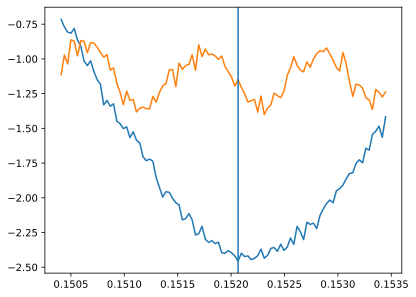

In [110]:
plt.plot(fine_tuning_amp01_range, fine01_51_iq)
plt.plot(fine_tuning_amp01_range, fine01_251_iq)
amp01_fined = fine_tuning_amp01_range[np.argmin(fine01_51_iq)]
plt.axvline(amp01_fined)

In [111]:
amp01_fined

0.15206546622401682